In [1]:
import os

import numpy as np
import pandas as pd
import scipy.linalg as LA
import scipy.sparse as sps

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

# %matplotlib notebook

## Reading the datasets

In [2]:
def fcps_reader(name, data_dir='../input/FCPS'):
    points = pd.read_csv(f"{data_dir}/{name}.lrn", sep='\t', comment='%', index_col=0, header=None)
    labels = pd.read_csv(f"{data_dir}/{name}.cls", sep='\t', comment='%', index_col=0, header=None)
    
    points = points.rename(columns= lambda x: f"x{x}")
    labels = labels.rename(columns={labels.columns[0]: 'y'})
    
    return pd.concat([points, labels], axis=1)

In [3]:
fcps_datasets = ['Atom', 'Chainlink', 'GolfBall', 'Hepta', 'Tetra']

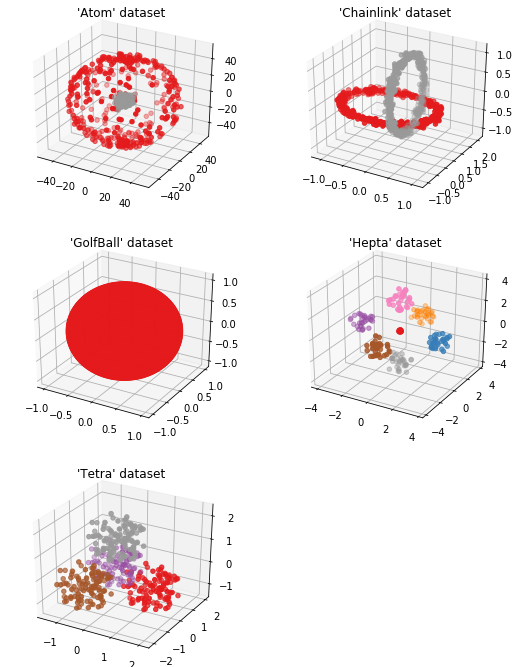

In [4]:
fig = plt.figure(figsize=(9,12))
for i, name in enumerate(fcps_datasets):
    data = fcps_reader(name)
    ax = fig.add_subplot(3,2,i+1, projection='3d')
    ax.scatter(data.x1, data.x2, data.x3, c=data.y, cmap='Set1')
    ax.set_title(f"{name!r} dataset")

In [5]:
data = fcps_reader('Tetra')
data.head()

,x1,x2,x3,y
0,,,,
1,1.295428,0.050829,-0.385217,1
2,1.409178,-0.035191,-0.251980,1
3,1.096803,0.246365,-0.415011,1
4,1.463328,0.265354,-0.513488,1
5,1.603284,0.080577,-0.470257,1


In [6]:
data.y.value_counts().sort_index()

1    100
2    100
3    100
4    100
Name: y, dtype: int64

In [7]:
X = data.iloc[:, :-1].values
y = data.y

In [8]:
n_neighbors=9

## Dimensionality reduction methods

In [9]:
%%time
pca = PCA(n_components=2).fit_transform(X)

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 13.5 ms


In [10]:
%%time
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 56.5 ms


In [11]:
%%time
isomap = Isomap(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 112 ms


In [12]:
%%time
mds = MDS(n_components=2).fit_transform(X)

CPU times: user 5.36 s, sys: 4.69 s, total: 10 s
Wall time: 1.29 s


### Auto-encoder

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self, encode_sizes, decode_sizes=None):
        super(AutoEncoder, self).__init__()
        if decode_sizes is None:
            decode_sizes = encode_sizes[::-1]
        
        self.encoder = AutoEncoder.make_sequential(encode_sizes)
        self.decoder = AutoEncoder.make_sequential(decode_sizes)
    
    @staticmethod
    def make_sequential(layer_sizes):
        n = len(layer_sizes)
        ls = layer_sizes
        # create fully connected layers with ReLU activations
        layers = [(nn.Linear(ls[i-1], ls[i]), nn.ReLU()) for i in range(1,n-1)]
        # unwrap tuples
        layers = [fn for layer in layers for fn in layer]
        # add the last layer
        layers += [nn.Linear(ls[n-2], ls[n-1])]
        # transform to sequential
        return nn.Sequential(*layers)
        

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    

In [14]:
num_epochs = 100

ae = AutoEncoder([3,3,2])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=.01, weight_decay=1e-5)

inputs = torch.tensor(X, dtype=torch.float)

for epoch in range(num_epochs):
    # ===================forward=====================
    enc, dec = ae(inputs)
    loss = criterion(dec, inputs)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [15]:
with torch.no_grad():
    ae_embed = ae.encode(inputs).numpy()

### Plotting the results of the dimensionality reduction methods

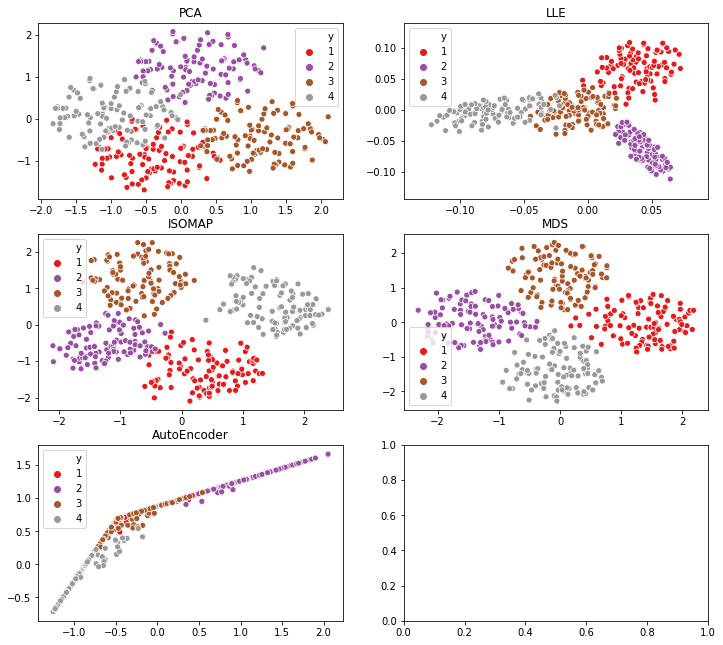

In [16]:
dimred = [("PCA", pca), ("LLE", lle), ("ISOMAP", isomap), ("MDS", mds), ("AutoEncoder", ae_embed)]

fig, axs = plt.subplots(3,2, figsize=(12,11))

for ax, (redname, redvals) in zip(axs.flat, dimred):
    sns.scatterplot(redvals[:, 0], redvals[:, 1], hue=y, ax=ax, palette='Set1', legend='full')
    ax.set_title(redname)

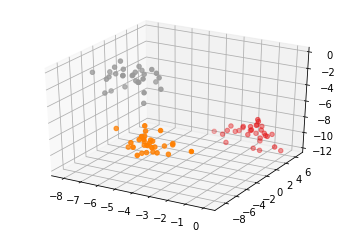

In [29]:
from sklearn.datasets import make_blobs
X_t, y_t = make_blobs(n_samples=90, n_features=3, centers=3, random_state=1)

ax = plt.axes(projection='3d')

ax.scatter(X_t[:,0], X_t[:,1], X_t[:,2], c=y_t, cmap='Set1')

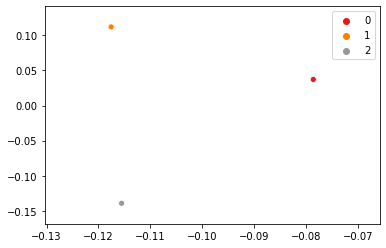

In [30]:
lleX = LocallyLinearEmbedding(n_neighbors=9).fit_transform(X_t)

sns.scatterplot(lleX[:,0], lleX[:,1],hue=y_t, palette='Set1')

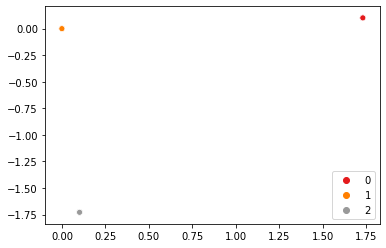

In [31]:
def LLE(X, k=5, d=2, reg=1E-3):
    n, r = X.shape

    # Step 1: compute pairwise distances
    
    knn = NearestNeighbors().fit(X)
#     print(X.shape, k, d)
    neighborhood = knn.kneighbors(X, n_neighbors=k+1, return_distance=False)[:, 1:]
#     dists = squareform(pdist(X))
#     index = np.argsort(dists, axis=1)
#     neighborhood = index[:,1:(k+1)]
    
    # Step 2: solve for the reconstruction weights W
    W = np.zeros((n,n))
    ones = np.ones(k)

    for i in range(n):
        nbrs = neighborhood[i,:]
        z = X[nbrs, :] - X[i, :]
        C = z @ z.T
        
        # regularization
        trace = float(C.trace())
        if trace > 0:
            C.flat[::k+1] += reg * trace
        else:
            C.flat[::k+1] += reg
        
#         W[i, nbrs] = LA.pinv(C) @ ones
        
        W[i, nbrs] = LA.solve(C, ones)
    
    W = W / W.sum(axis=1)[:, np.newaxis]
    
#     csr_matrix((data, (row_ind, col_ind))
       
    # Step 3: compute the embedding from the eigenvectors
    #   of the cost matrix M = (I-W)'(I-W) = W'W - W - W' + I
#     M = W.T @ W - W - W.T
#     M.flat[::M.shape[0]+1] += 1
    
    W.flat[::W.shape[0]+1] -= 1 # W - I
    # calculate the embeddings
    u, w, v = LA.svd(W)
#     print(vT)
    idx = np.argsort(w)[1:(d+1)]
    Y = v.T[:, idx] * n**.5
    
#     print(u.T)
            
    return W, Y

S, mylleX = LLE(X_t, k=9)

sns.scatterplot(mylleX[:,0], mylleX[:,1],hue=y_t, palette='Set1')

(90, 2)


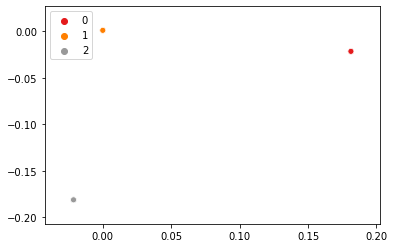

In [32]:
def github_LLE(X,k,d):
    """
     - X is a numpy array of rank (d,N), consisting of N
        data points in d dimensions.
     - k is the number of neighbors to use in the embedding
     - m is the number of dimensions to which the dataset will
        be reduced.
    """
    X = np.matrix(X)
    _, N = X.shape
    assert d < N

    #build the weight matrix
    W = np.zeros((N,N))
    
    for row in range(N):
        #-----------------------------------------------
        #  find k nearest neighbors
        #-----------------------------------------------
        C = np.array(X-X[:,row])
        vec = (C**2).sum(0)
        nbrs = np.argsort(vec)[1:k+1]
        
        #-----------------------------------------------
        #  compute weight vector based on neighbors
        #-----------------------------------------------

        #compute covariance matrix of distances
        C = np.matrix(C[:,nbrs])
        G = C.T @ C
        
        # handle the case when G is singular and has 0 trace
        # see https://github.com/scikit-learn/scikit-learn/blob/b194674c42d54b26137a456c510c5fdba1ba23e0/sklearn/manifold/_locally_linear.py#L20
        trace = float(G.trace())
        if trace > 0:
            R = .001 * trace
        else:
            R = .001
            
        G.flat[::k+1] += R
    
        #solve for weight
        w = LA.solve(G,np.ones(G.shape[0])) 
#         w = LA.pinv(G) @ np.ones(G.shape[0])
        w /= np.sum(w)

        #update row of the weight matrix
        W[row,nbrs] = w

#     print(W)
#     print((W - W.T).sum())
    
    
    #to find the null space, we need the bottom d+1
    #  eigenvectors of (W-I).T*(W-I)
    #Compute this using the svd of (W-I):
    I = np.identity(W.shape[0])
    U, sig, VT = LA.svd(W-I, full_matrices=False)
#     print(VT)
    indices = np.argsort(sig)[1:d+1]

    return W, np.array(VT[indices,:])

W, tmp = github_LLE(X_t.T, 9, 2)
tmp = tmp.T
print(tmp.shape)
sns.scatterplot(tmp[:,0], tmp[:,1],hue=y_t, palette='Set1')

In [247]:
tmp = NearestNeighbors().fit(X_t)
?tmp.kneighbors

In [23]:
(NearestNeighbors().fit(X_t)
 .kneighbors(X_t, n_neighbors=5+1, return_distance=False)[:, 1:] == np.argsort(squareform(pdist(X_t)), axis=1)[:,1:(5+1)]).mean()

1.0

In [328]:
def loss(X, encoded, decoded, S, l):
    """Computes the autoencoder loss
    loss = ||X - decoded||^2 + l * ||encoded - S*encoded||^2
    the autoencoder should keep as much information while also
    keeping the neighborhoods as separate as possible // could be better phrased
    """
    sim = X - decoded # how similar the result is to the input
    sep = encoded - S @ encoded # how well separated the embedding is
    
    return (sim ** 2).sum() + l * (sep ** 2).sum()

In [329]:
fcps_datasets

['Atom', 'Chainlink', 'GolfBall', 'Hepta', 'Tetra']

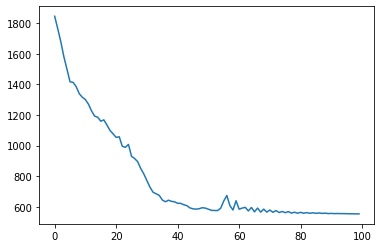

In [339]:
train = fcps_reader(fcps_datasets[-2])
X_train = train.iloc[:, :-1].values
y_train = train.y

# X_train = X_t
# y_train = y_t 

num_epochs = 100

ae = AutoEncoder([3,3,2])
optimizer = torch.optim.Adam(ae.parameters(), lr=.1, weight_decay=1e-5)
inputs = torch.tensor(X_train, dtype=torch.float)

losses = []

for epoch in range(num_epochs):
    # encode
    enc, dec = ae(inputs)
    # compute
    X_enc = enc.detach().numpy()
    S, _ = LLE(X_enc, 9, X_enc.shape[1])
    
    cost = loss(inputs, enc, dec, torch.Tensor(S.T), l=1)
#     print(f"Loss:\t{cost.item():.3f}")
    losses.append(cost.item())
    
    # update autoencoder weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
plt.plot(losses)

Text(0.5, 1.0, 'LLE coordinates')

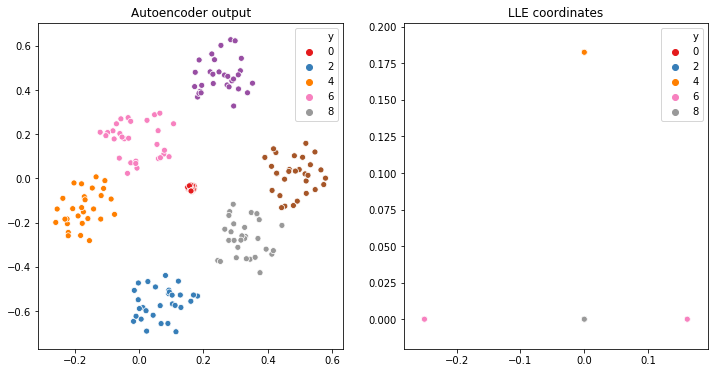

In [340]:
with torch.no_grad():
    ae_lle_embed = ae.encode(inputs).numpy()

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(ae_lle_embed[:,0], ae_lle_embed[:,1],hue=y_train, palette='Set1', ax=axs[0])
axs[0].set_title('Autoencoder output')
_, Y = github_LLE(ae_lle_embed.T, 5, ae_lle_embed.shape[1])
sns.scatterplot(Y.T[:,0], Y.T[:,1],hue=y_train, palette='Set1', ax=axs[1], '')
axs[1].set_title('LLE coordinates')

In [343]:
import scipy.sparse as sps

In [406]:
a = sps.csr_matrix([[1,1,0,0,1], [1,0,1,1,0], [1,1,1,0,1]])
a

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [407]:
a.data

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [408]:
a.indices

array([0, 1, 4, 0, 2, 3, 0, 1, 2, 4], dtype=int32)

In [409]:
a.indptr

array([ 0,  3,  6, 10], dtype=int32)

In [410]:
rows = []
for i,v in enumerate(a.indptr[1:]):
    count = v - a.indptr[i]
    rows += [i for _ in range(count)]
print(rows)
print(a.indices)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 2]
[0 1 4 0 2 3 0 1 2 4]


In [411]:
sps.csr_matrix((a.data, (rows, a.indices)), shape=a.shape).toarray()

array([[1, 1, 0, 0, 1],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 0, 1]], dtype=int64)

In [412]:
a.toarray()

array([[1, 1, 0, 0, 1],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 0, 1]], dtype=int64)

In [416]:
sps.linalg.svds(a.asfptype(), k=min(a.shape)-1, which='SM')

(array([[-0.67321773,  0.48483601],
        [-0.26367473, -0.86280911],
        [ 0.69083538,  0.14315891]]),
 array([0.55960293, 1.45128527]),
 array([[-0.43969943,  0.03148241,  0.76332811, -0.47118184,  0.03148241],
        [-0.16179741,  0.43271639, -0.49587095, -0.5945138 ,  0.43271639]]))

In [414]:
LA.svd(a.toarray())

(array([[-0.55831168,  0.48483601, -0.67321773],
        [-0.43131898, -0.86280911, -0.26367473],
        [-0.7086974 ,  0.14315891,  0.69083538]]),
 array([2.75329178, 1.45128527, 0.55960293]),
 array([[-6.16835481e-01, -4.60179733e-01, -4.14055783e-01,
         -1.56655748e-01, -4.60179733e-01],
        [-1.61797410e-01,  4.32716386e-01, -4.95870953e-01,
         -5.94513796e-01,  4.32716386e-01],
        [-4.39699428e-01,  3.14824080e-02,  7.63328112e-01,
         -4.71181836e-01,  3.14824080e-02],
        [-5.85410197e-01,  5.60321666e-01, -1.66533454e-16,
          5.85410197e-01,  2.50885310e-02],
        [-2.39363535e-01, -5.34826730e-01, -2.77555756e-17,
          2.39363535e-01,  7.74190264e-01]]))

In [400]:
sps.linalg.eigs((a.T @ a).asfptype(), k=2)

(array([6.94338091+0.j, 1.6090937 +0.j]),
 array([[ 0.61865931+0.j,  0.45951072+0.j],
        [ 0.51456716+0.j, -0.29490641+0.j],
        [ 0.27724853+0.j, -0.21392784+0.j],
        [ 0.10409215+0.j,  0.75441713+0.j],
        [ 0.51456716+0.j, -0.29490641+0.j]]))

In [403]:
b = a.toarray()
b

array([[1, 1, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 1, 1, 0, 1]], dtype=int64)

In [405]:
LA.eig((b @ b.T))

(array([6.94338091+0.j, 0.44752539+0.j, 1.6090937 +0.j]),
 array([[ 0.62534161,  0.77356073,  0.10272136],
        [ 0.2742859 , -0.09465353, -0.95697855],
        [ 0.73055809, -0.62661353,  0.27136759]]))

In [418]:
X = np.arange(20).reshape((-1,2))
X

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [423]:
-2 * X @ X.T + (X**2).sum(axis=1) + (X**2).sum(axis=1)[:, None]

array([[  0,   8,  32,  72, 128, 200, 288, 392, 512, 648],
       [  8,   0,   8,  32,  72, 128, 200, 288, 392, 512],
       [ 32,   8,   0,   8,  32,  72, 128, 200, 288, 392],
       [ 72,  32,   8,   0,   8,  32,  72, 128, 200, 288],
       [128,  72,  32,   8,   0,   8,  32,  72, 128, 200],
       [200, 128,  72,  32,   8,   0,   8,  32,  72, 128],
       [288, 200, 128,  72,  32,   8,   0,   8,  32,  72],
       [392, 288, 200, 128,  72,  32,   8,   0,   8,  32],
       [512, 392, 288, 200, 128,  72,  32,   8,   0,   8],
       [648, 512, 392, 288, 200, 128,  72,  32,   8,   0]])

In [424]:
labels = np.array([1,1,2,1,1,2,3,1,2,2,2])
classes = np.unique(labels)

In [425]:
labels

array([1, 1, 2, 1, 1, 2, 3, 1, 2, 2, 2])

In [426]:
classes

array([1, 2, 3])

In [428]:
(classes[:, np.newaxis] == labels)*1

array([[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])